# 딥러닝을 적용한 추천 시스템
- 딥러닝을 어떻게 추천에 적용할 수 있는지 생각해 보면, 우선 추천을 위한 입력으로 사용자와 아이템의 특성을 나타낼 수 있는 embedding 데이터가 필요하다. 사용자와 아이템을 embidding해서 입력으로 넣으면 사용자와 아이템 간의 특성을 학습해서 추천(예측)에 이용할 수 있다.

![DNN](data/DNN.jpg)

- 이와 같이 One-hot representation 으로 변환하고 (input layer), 이를 잠재요인(Embedding Layer)으로 연결시킨다. 그러면 사용자 잠재요인(User latent Vector)과 아이템 잠재요인 (Item Latent vector)이 만들어지는데, 이둘을 합쳐서 신경망의 첫번째 층인 레이어 1이 만들어진다. 사용자 잠재요인과 아이템 잠죠요인을 합치는 가장 단순한 방법은 인공신경망에서 사용되는 결합(concatenate)을 이용해서 앞뒤로 그래도 붙이는 방법이다. 일단 첫 번째 층이 만들어지면, 그 다음부터는 일반적인 DL에서와 같이 적절한 층을 쌓아나가면 된다. 맨 끝(위)에는 출력으로 예측하고자 하는 평점이 놓이기 된다. 

In [1]:
import pandas as pd
import numpy as np

from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, Adamax

In [2]:
# csv 파일에서 불러오기
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('data/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)

# train test 분리
TRAIN_SIZE = 0.75
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [3]:
# Variable 초기화 
K = 200                             # Latent factor 수 (잠재요인 수)
mu = ratings_train.rating.mean()    # 전체 평균 
M = ratings.user_id.max() + 1       # Number of users
N = ratings.movie_id.max() + 1      # Number of movies

# Defining RMSE measure
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [4]:
# Keras model
user = Input(shape=(1, ))                                               # User input
item = Input(shape=(1, ))                                               # Item input
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)        # (M, 1, K)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)        # (N, 1, K)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)          # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)          # Item bias term (N, 1, )

In [5]:
# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation
P_embedding = Flatten()(P_embedding)                                    # (K, )
Q_embedding = Flatten()(Q_embedding)                                    # (K, )
user_bias = Flatten()(user_bias)                                        # (1, )
item_bias = Flatten()(item_bias)                                        # (1, )
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])     # (2K + 2, )

In [6]:
# Neural network
R = Dense(2048)(R) # 노드가 2048개인 dense layer 추가
R = Activation('linear')(R) 
R = Dense(256)(R)  # 노드가 256개인 dense layer 추가
R = Activation('linear')(R)
R = Dense(1)(R)

In [7]:
model = Model(inputs=[user, item], outputs=R)
model.compile(
  loss=RMSE,
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RMSE]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 200)       188800      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 200)       336600      input_2[0][0]                    
______________________________________________________________________________________________

In [8]:
# Model fitting
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.movie_id.values],
  y=ratings_train.rating.values - mu,
  epochs=65,
  batch_size=512,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.movie_id.values],
    ratings_test.rating.values - mu
  )
)

Train on 75000 samples, validate on 25000 samples
Epoch 1/65


C:\Users\user\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


  512/75000 [..............................] - ETA: 1:51 - loss: 5.6078 - RMSE: 1.2035

C:\Users\user\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


75000/75000 [==============================] - 7s 88us/sample - loss: 5.4015 - RMSE: 1.1232 - val_loss: 5.2859 - val_RMSE: 1.1332
Epoch 2/65
75000/75000 [==============================] - 6s 79us/sample - loss: 5.1555 - RMSE: 1.1212 - val_loss: 5.0476 - val_RMSE: 1.1320
Epoch 3/65
75000/75000 [==============================] - 6s 84us/sample - loss: 4.9236 - RMSE: 1.1201 - val_loss: 4.8224 - val_RMSE: 1.1303
Epoch 4/65
75000/75000 [==============================] - 7s 89us/sample - loss: 4.7050 - RMSE: 1.1181 - val_loss: 4.6103 - val_RMSE: 1.1290
Epoch 5/65
75000/75000 [==============================] - 7s 88us/sample - loss: 4.4987 - RMSE: 1.1171 - val_loss: 4.4103 - val_RMSE: 1.1277
Epoch 6/65
75000/75000 [==============================] - 7s 99us/sample - loss: 4.3044 - RMSE: 1.1153 - val_loss: 4.2217 - val_RMSE: 1.1264
Epoch 7/65
75000/75000 [==============================] - 8s 100us/sample - loss: 4.1209 - RMSE: 1.1138 - val_loss: 4.0436 - val_RMSE: 1.1248
Epoch 8/65
75000/75000 

75000/75000 [==============================] - 9s 116us/sample - loss: 1.0847 - RMSE: 0.9175 - val_loss: 1.1161 - val_RMSE: 0.9532
Epoch 59/65
75000/75000 [==============================] - 9s 114us/sample - loss: 1.0755 - RMSE: 0.9165 - val_loss: 1.1077 - val_RMSE: 0.9533
Epoch 60/65
75000/75000 [==============================] - 9s 121us/sample - loss: 1.0672 - RMSE: 0.9168 - val_loss: 1.1013 - val_RMSE: 0.9550
Epoch 61/65
75000/75000 [==============================] - 9s 118us/sample - loss: 1.0590 - RMSE: 0.9164 - val_loss: 1.0915 - val_RMSE: 0.9527
Epoch 62/65
75000/75000 [==============================] - 9s 116us/sample - loss: 1.0514 - RMSE: 0.9161 - val_loss: 1.0863 - val_RMSE: 0.9546
Epoch 63/65
75000/75000 [==============================] - 9s 115us/sample - loss: 1.0442 - RMSE: 0.9157 - val_loss: 1.0773 - val_RMSE: 0.9524
Epoch 64/65
75000/75000 [==============================] - 9s 116us/sample - loss: 1.0378 - RMSE: 0.9161 - val_loss: 1.0714 - val_RMSE: 0.9528
Epoch 65/65

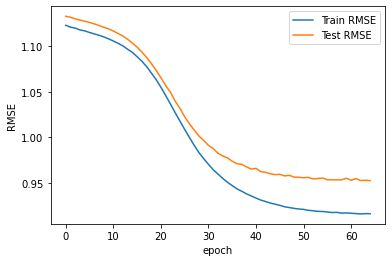

In [9]:
# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [10]:
# Prediction
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
predictions = model.predict([user_ids, movie_ids]) + mu
print("Actuals: \n", ratings_test[0:6])
print()
print("Predictions: \n", predictions)

Actuals: 
        user_id  movie_id  rating
6255        41       313       3
27473      377        98       5
47489      659       393       3
62158      889       654       3
24063      472       195       5
29045      534       117       5

Predictions: 
 [[4.197077 ]
 [4.6141233]
 [3.516865 ]
 [3.9705737]
 [4.797143 ]
 [4.441509 ]]


In [11]:
# 정확도(RMSE)를 계산하는 함수 
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)


0.9527972545552432